In [1]:
import numpy as np
from scripts_topo.mesh import *
from scripts_topo.simulation import *

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.25,rc={"lines.linewidth": 2})
sns.set_style("white")

import warnings
warnings.filterwarnings('ignore')

# Valve failure simulation

### segment size properties Vs. valve failure rates

In [2]:
def get_segments(mesh,fail_rate):
    valve_register = mesh.valve_register
    valve_register.recover_valves()
    vids2fail = generate_vids2fail(mesh.valid_vids,fail_rate)
    valves_dict = fail_valves(valve_register.vid2v,vids2fail)
    segments = simulate_segments(mesh.grid_size,valves_dict)
    return segments

In [3]:
def filter_pids(pids,mesh):
    topo_pids = mesh.topo_pids
    pids = set(pids)-topo_pids
    return pids

def get_seg_sizes(segments,mesh):
    sizes = []
    for segment in segments:
        pids = filter_pids(segment.pids,mesh)
        size = len(pids)         
        if size > 0:
            sizes.append(size)
    sizes = sorted(sizes)
    sizes = np.array(sizes)
    return sizes

In [4]:
def segment_size_sim(mesh,fail_rates,mc = 50):
    means,stds,counts,largest,second_largest = [],[],[],[],[]
    for fail_rate in fail_rates:
        mc_means,mc_stds,mc_count,mc_largest,mc_second_largest = [],[],[],[],[]
        for _ in range(mc):
            segments = get_segments(mesh,fail_rate)
            sizes = get_seg_sizes(segments,mesh)
            p = sum(sizes[sizes>2])/len(mesh.valid_pids)
            
            mc_means.append(np.mean(sizes)/len(mesh.valid_pids)*100)
            mc_stds.append(np.std(sizes)/len(mesh.valid_pids)*100)
            mc_count.append(np.sum(sizes>2))
            mc_largest.append(sizes[-1])
            sl = sizes[-2] if len(sizes) > 1 else sizes[-1]
            mc_second_largest.append(sl)
            

        means.append(np.mean(mc_means))
        stds.append(np.mean(mc_stds))
        counts.append(np.mean(mc_count))
        largest.append(np.mean(mc_largest))
        second_largest.append(np.mean(mc_second_largest))
        
    return np.array(means),np.array(stds),np.array(counts),np.array(largest),np.array(second_largest)

In [5]:
def get_mesh_stats(param):
    try:
        fail_rates,mesh_settings = param
        mesh = create_mesh(mesh_settings)
        sparseness = calculate_sparseness(mesh)
    #     print (f'sparseness of the created mesh (compare to the grid network) {sparseness}')
        means,stds,counts,largest,second_largest = segment_size_sim(mesh,fail_rates)
        return (sparseness,means,stds,counts,largest,second_largest)
    except Exception:
#         print (Exception)
        return None

In [6]:
def mc_mesh_stats(fail_rates,mesh_settings,num_sim = 50):
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.map(get_mesh_stats, [((fail_rates,mesh_settings)) for i in range(num_sim)])
    pool.close()
    return results

In [7]:
grid_size = 10
fail_rates = np.linspace(0,0.99,10)
sim_num = 100

In [8]:
sparse_setting  = generate_sparse_mesh_settings(grid_size)
sparse_result = mc_mesh_stats(fail_rates,sparse_setting,sim_num)

In [9]:
med_setting  = generate_med_mesh_settings(grid_size)
med_result = mc_mesh_stats(fail_rates,med_setting,sim_num)

In [10]:
high_setting  = generate_high_mesh_settings(grid_size)
high_setting['contraction_ratio'] = 0
high_setting['degree_settings'][3] = 1
high_setting['degree_settings'][4] = 1
high_setting['degree_settings'][5] = 1
high_setting['degree_settings'][6] = 1

high_result = mc_mesh_stats(fail_rates,high_setting,sim_num)

In [11]:
def extract_result(results):
    sparseness_list,means_list,stds_list,counts_list,largest,second_largest = [],[],[],[],[],[]
    for result in results:
        if result:
            sparseness,means,stds,counts,l, sl = result
            sparseness_list.append(sparseness)
            means_list.append(means)
            stds_list.append(stds)
            counts_list.append(counts)
            largest.append(l)
            second_largest.append(sl)
            
    return (sparseness_list,take_average(means_list),
            take_average(stds_list),take_average(counts_list),
            take_average(largest),take_average(second_largest),
           )

def take_average(res_list):
    mean_res = np.zeros_like(fail_rates)
    count =0
    for mean in res_list:
        mean_res+=mean
        count+=1
    ave = mean_res/count
#     ave[-1] = 100
    return ave
        

In [12]:
sparseness0,sparse_mean,sparse_std,sparse_count,sparse_l,sparse_sl = extract_result(sparse_result)
sparseness1,med_mean,med_std,med_count,med_l,med_sl = extract_result(med_result)
sparseness2,high_mean,high_std,high_count,high_l, high_sl = extract_result(high_result)

### Visualizations

Text(0,0.5,'Largest Segment Size Ratio (%)')

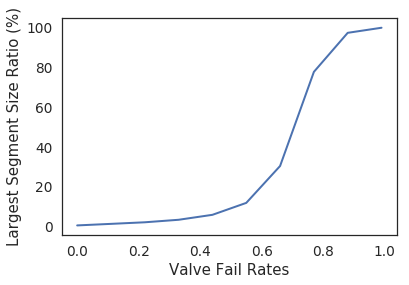

In [13]:
# plt.plot(fail_rates, sparse_mean,label='high')
# plt.plot(fail_rates, np.log(med_mean),label='medium')
plt.plot(fail_rates, high_l/max(high_l) * 100)
# plt.plot(fail_rates, high_sl,label='second largest')
# plt.legend()
plt.xlabel('Valve Fail Rates')
plt.ylabel('Largest Segment Size Ratio (%)')
# save_name = './figures_clean/largest_size_lattice.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)

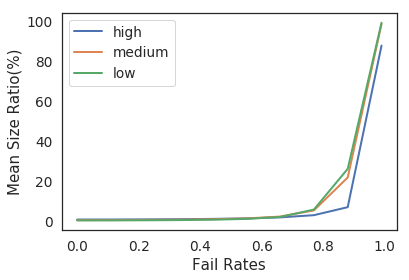

In [14]:
num = 40
plt.plot(fail_rates[:num], sparse_mean[:num],label='high')
plt.plot(fail_rates[:num], med_mean[:num],label='medium')
plt.plot(fail_rates[:num], high_mean[:num],label='low')
plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('Mean Size Ratio(%)')
save_name = './figures_clean/segment_mean_size_topo.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)

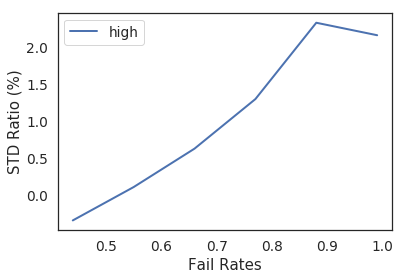

In [15]:
plt.plot(fail_rates[4:], np.log(sparse_std[4:]),label='high')
# plt.plot(fail_rates, med_std,label='medium')
# plt.plot(fail_rates, high_std,label='low')
plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('STD Ratio (%)')
save_name = './figures_clean/segment_std_size_topo.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)


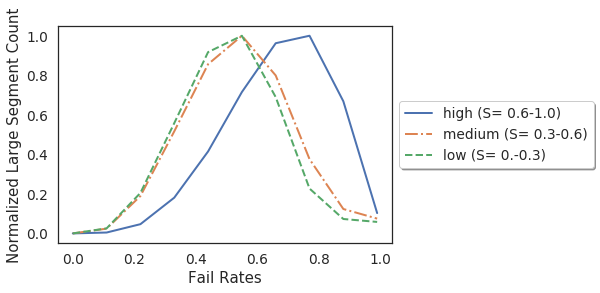

In [16]:
plt.plot(fail_rates, sparse_count/np.max(sparse_count),label='high (S= 0.6-1.0)')
plt.plot(fail_rates, med_count/np.max(med_count),linestyle='dashdot',label='medium (S= 0.3-0.6)')
plt.plot(fail_rates, high_count/np.max(high_count),linestyle='dashed',label='low (S= 0.-0.3)')

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('Fail Rates')
plt.ylabel('Normalized Large Segment Count')
# plt.legend(loc='upper left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
save_name = './risk_figures/theory/segment_count_topo.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)
# plt.title(f'valve fail rate: {fail_rate}')

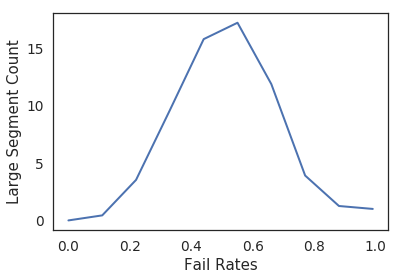

In [17]:
# plt.plot(fail_rates, sparse_count/np.max(sparse_count))
# plt.plot(fail_rates, med_count/np.max(med_count))
plt.plot(fail_rates, high_count)

# # plt.plot(fail_rates, topo_report4[2], label="tree-like", linewidth=2)
plt.xlabel('Fail Rates')
plt.ylabel('Large Segment Count')

save_name = 'risk_figures/theory/segment_count_mesh.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)
# plt.title(f'valve fail rate: {fail_rate}')

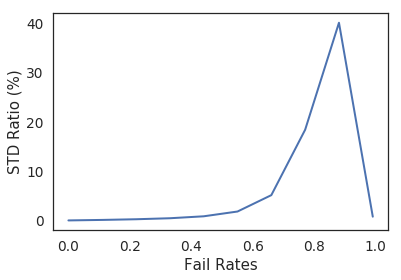

In [18]:
plt.plot(fail_rates, high_std,label='low')
# plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('STD Ratio (%)')
save_name = './figures_clean/segment_std_size_mesh.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)

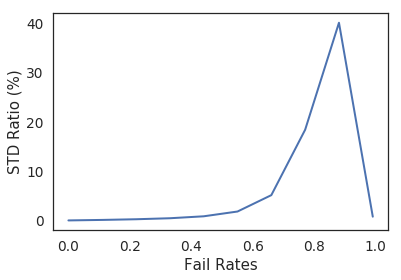

In [19]:
num = 30
plt.plot(fail_rates[:num], high_std[:num],label='low')
# plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('STD Ratio (%)')
save_name = './figures_clean/segment_std_size_zoom.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)

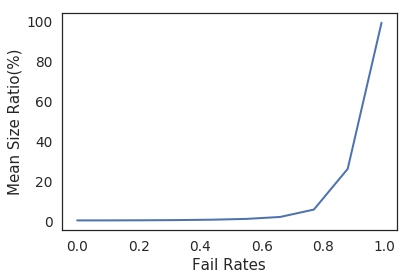

In [20]:
plt.plot(fail_rates, high_mean,label='low')
# plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('Mean Size Ratio(%)')
save_name = './figures_clean/segment_mean_size_mesh.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)

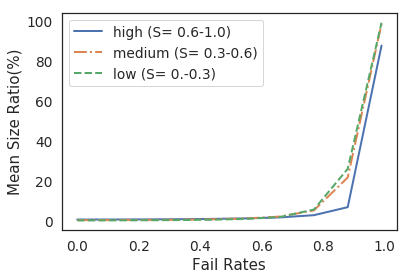

In [21]:
num = 3000
plt.plot(fail_rates[:num], sparse_mean[:num],label='high (S= 0.6-1.0)')
plt.plot(fail_rates[:num], med_mean[:num],linestyle='dashdot',label= 'medium (S= 0.3-0.6)')
plt.plot(fail_rates[:num], high_mean[:num],linestyle='dashed',label='low (S= 0.-0.3)')
plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('Mean Size Ratio(%)')
# save_name = './figures_clean/segment_mean_size_zoom.png'
save_name = './risk_figures/theory/segment_mean_size_topo.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)

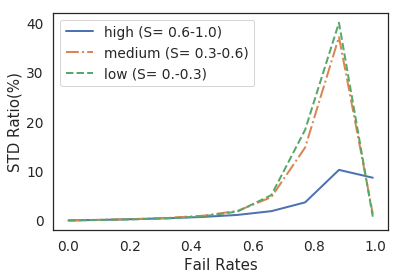

In [22]:
num = 3000
plt.plot(fail_rates[:num], sparse_std[:num],label='high (S= 0.6-1.0)')
plt.plot(fail_rates[:num], med_std[:num],linestyle='dashdot',label= 'medium (S= 0.3-0.6)')
plt.plot(fail_rates[:num], high_std[:num],linestyle='dashed',label='low (S= 0.-0.3)')
plt.legend()
plt.xlabel('Fail Rates')
plt.ylabel('STD Ratio(%)')
save_name = './risk_figures/theory/segment_std_size_topo.png'
# plt.savefig(save_name,bbox_inches='tight',dpi=300)